# Step 2

### Target
- Decrease the number of model parameters
  - Reduce the number of kernels
  - Use 1x1 kernel before GAP
  - Add Global Average Pooling (GAP)

- Decrease Batch Size  
  Small batch size helps the model to escape any local minima

### Result
- Parameters: 8,962
- Best Training Accuracy: 98.92
- Best Test Accuracy: 98.94

### Analysis
- Light Model
- Model is training well, the accuracy is increasing steadily with extremely less fluctuations
- Model is still capable of getting better accuracy if pushed further


# Installing Packages
The following packages need to be installed before running the code below
- torchsummary

In [1]:
!pip install torchsummary

# Imports
Importing necessary packages

In [0]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms

# Dataset Preparation and Loading
The following steps are performed for preparing the dataset for the model.
- Downloading the MNIST dataset
- Visualizing the dataset and the data statistics
- Defining data transformations
- Splitting the dataset into train and test set
- Creating data loader for train and test set

## Data Visualization and Statistics
Let's see how our data looks like and what are the mean and standard deviation values of the dataset. This information will help us decide the transformations that can be used on the dataset.

Data Statistics:
 - Data Shape: (60000, 28, 28)
 - min: 0.0
 - max: 1.0
 - mean: 0.1307
 - std: 0.3081
 - var: 0.0949



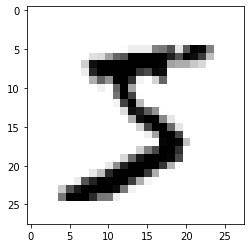

In [3]:
# Download data
sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setti32ng the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

# Display some data statistics
print('Data Statistics:')
print(' - Data Shape:', sample_data.shape)
print(' - min:', np.min(sample_data))
print(' - max:', np.max(sample_data))
print(' - mean: %.4f' % np.mean(sample_data))
print(' - std: %.4f' % np.std(sample_data))
print(' - var: %.4f\n' % np.var(sample_data))

# Visualize a sample from the data
plt.imshow(sample_data[0], cmap='gray_r')

Let's view some more images. This will help in getting any ideas for data augmentation later on

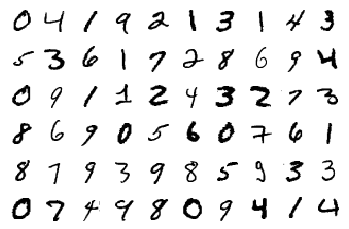

In [4]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(sample_data[index], cmap='gray_r')

## Data Transformations

The following transformations will be used
- ToTensor
- Normalize

In [0]:
# Train phase transformations
train_transforms = transforms.Compose([
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation
    # these values were obtained from the data statistics above
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Train Data and Test Data Split
The data is downloaded and split into two sets: train and test

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Train and Test Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [7]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Architecture
Designing the model structure

In [0]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU()
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU()
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU()
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters
Let's see the model summary

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             584
              ReLU-4            [-1, 8, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,168
              ReLU-6           [-1, 16, 22, 22]               0
            Conv2d-7           [-1, 16, 20, 20]           2,320
              ReLU-8           [-1, 16, 20, 20]               0
         MaxPool2d-9           [-1, 16, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           2,320
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           2,320
             ReLU-13             [-1, 16, 6, 6]               0
           Conv2d-14             [

# Model Training and Evaluation
Training the model and testing it on the test dataset

In [0]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100 * correct / processed)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={train_accuracies[-1]:.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracies[-1]:.2f}%)\n')

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 15

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 2.2999, Accuracy: 1035/10000 (10.35%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3877, Accuracy: 8777/10000 (87.77%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1469, Accuracy: 9553/10000 (95.53%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0878, Accuracy: 9725/10000 (97.25%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 9777/10000 (97.77%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9768/10000 (97.68%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9750/10000 (97.50%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9830/10000 (98.30%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9866/10000 (98.66%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9864/10000 (98.64%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9867/10000 (98.67%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9877/10000 (98.77%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9894/10000 (98.94%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9840/10000 (98.40%)

Epoch 15:


Loss=0.01 Batch_ID=937 Accuracy=98.91: 100%|██████████| 938/938 [00:14<00:00, 62.68it/s]



Test set: Average loss: 0.0380, Accuracy: 9875/10000 (98.75%)



## Result Analysis
Plotting various metrics obtained during training and testing and analyzing them for futher improvement

Text(0.5, 1.0, 'Test Accuracy')

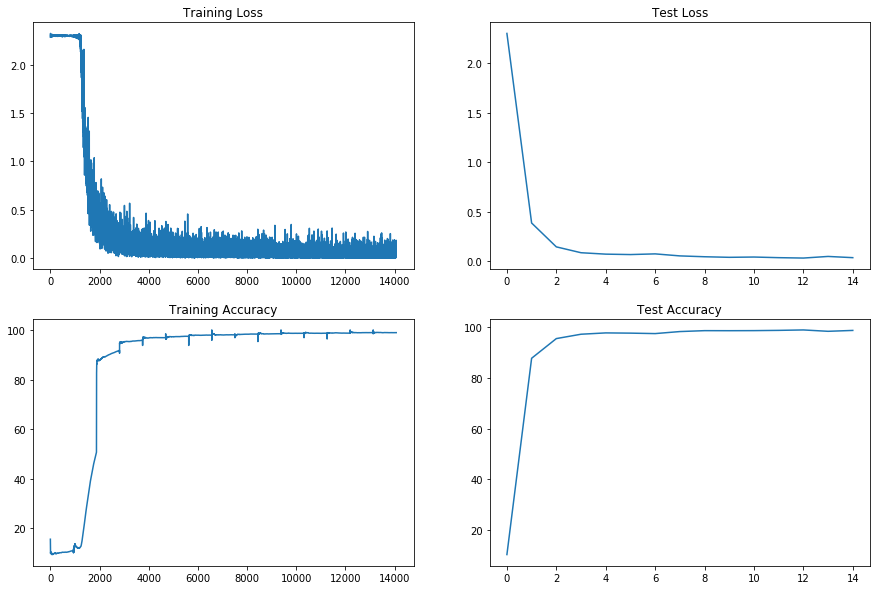

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")